# FUNNEL ANALYSIS

## Objective
To synthesize all previously cleaned datasets into a single, master view of the student acquisition funnel. This notebook will focus on calculating and visualizing key conversion rates, analyzing funnel velocity, determining the cost-effectiveness of marketing efforts, and ultimately, deriving actionable insights to optimize the entire admissions process from lead to enrollment.

## Methodology & Analysis Performed
To achieve the objective, the following analytical steps were performed:

- Data Synthesis: Five distinct datasets (Leads, Applications, Tests, Tokens, Campaign Performance) were merged into a single master DataFrame to create a complete view of the candidate journey.

- Funnel Visualization: The overall conversion funnel was calculated and visualized to identify the primary drop-off points between the Lead, Application, Test, and Token stages.

- Deep-Dive Exploratory Data Analysis (EDA): A series of deep dives were conducted to understand the factors influencing conversion, including:

- Marketing ROI: Analyzed Cost Per Lead (CPL), Cost Per Application (CPA), and Cost Per Token (CPT) for each campaign and ad creative.

- Funnel Velocity: Measured the average time from lead to token and the time between each specific stage to identify process bottlenecks.

- Candidate Profiling: Investigated how factors like work experience, academic background, and entrance test performance correlate with enrollment rates.

- Operational Efficiency: Examined the performance of admissions counselors and analyzed the primary reasons for lead loss.

- Predictive Modeling: A logistic regression model was developed to create a lead score, predicting the likelihood of a new lead converting to an enrolled student based on their initial characteristics.

#### Setup and Library Installation

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Plotting and display settings ---
pio.templates.default = "plotly_dark"
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Libraries imported successfully.")

Libraries imported successfully.


#### Load the Cleaned Data

In [193]:
try:
    leads_df = pd.read_csv(r"C:\Users\aadhi\Documents\Internship\MBA Tech\Cleaned Datasets\Performance_Marketing_Leads_Cleaned.csv")
    apps_df = pd.read_csv(r"C:\Users\aadhi\Documents\Internship\MBA Tech\Cleaned Datasets\Applications_cleaned.csv")
    tests_df = pd.read_csv(r"C:\Users\aadhi\Documents\Internship\MBA Tech\Cleaned Datasets\MBA_Tests_cleaned.csv")
    tokens_df = pd.read_csv(r"C:\Users\aadhi\Documents\Internship\MBA Tech\Cleaned Datasets\MBA_Tokens_cleaned.csv")
    campaign_df = pd.read_csv(r"C:\Users\aadhi\Documents\Internship\MBA Tech\Cleaned Datasets\MBA_Tech_Campaign_performance_cleaned.csv")
    print("\nAll datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"\nError loading datasets: {e}. Please ensure all CSV files are in the correct directory.")


All datasets loaded successfully.


##### Standardize join keys and prepare for merge

In [194]:
# Utility function for deduplication
def deduplicate(df, key="email"):
    return df.drop_duplicates(subset=key, keep="first")

# Apply deduplication
apps_df = deduplicate(apps_df)
tests_df = deduplicate(tests_df.rename(columns={"email_id": "email"}))
tokens_df = deduplicate(tokens_df)

#### Merge Dataset to build the Funnel

In [195]:
# --- Sequential merge of student journey data ---
funnel_df = pd.merge(leads_df, apps_df, on='email', how='left', suffixes=('_lead', '_app'))
funnel_df = pd.merge(funnel_df, tests_df, on='email', how='left', suffixes=('', '_test'))
funnel_df = pd.merge(funnel_df, tokens_df, on='email', how='left', suffixes=('', '_token'))

# --- Aggregate and merge campaign performance data ---
funnel_df['campaign_id'] = pd.to_numeric(funnel_df['campaign_id'], errors='coerce')
campaign_df['campaign_id'] = pd.to_numeric(campaign_df['campaign_id'], errors='coerce')

# Aggregate campaign data, keeping all necessary columns to prevent KeyErrors later
campaign_agg_df = campaign_df.groupby('campaign_id').agg({
    'campaign_name': 'first',
    'creative_name': 'first',
    'total_spent': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'leads': 'sum'
}).reset_index()

full_funnel_df = pd.merge(funnel_df, campaign_agg_df, on='campaign_id', how='left', suffixes=('', '_campaign'))
print("Datasets merged successfully into a single master DataFrame.")

Datasets merged successfully into a single master DataFrame.


#### Data intro

In [196]:
full_funnel_df.head()

,lead_id,created_time,ad_id,campaign_id,form_id,form_name,platform,name_lead,email,phone_lead,graduation_degree,graduation_percentage,work_experience,upload_date,contacted,lead_stage_lead,token_paid,ad_set_id,first_call,candidate_id,answered,lsq_created_date,last_call_date,owner,city,opportunity_status,opportunity_mapped,status,max_call_duration,lead_month,lead_day_of_week,lead_hour,lead_category,degree_category_lead,is_weekend,time_of_day,is_email_valid,is_phone_valid,application,program,batch,name_app,phone_app,current_status,completed_step,submission_date,general_manager,source,date_of_birth,current_country,current_state,current_city,current_pincode,permanent_country,permanent_state,permanent_city,permanent_pincode,identity_proof,x_school_name,x_passing_year,x_percentage,xii_school_name,xii_board,xii_specialization,xii_year,xii_percentage,bachelor_degree,bachelor_other_degree,branch_bachelor,bachelor_percentage,bachelor_passing_year,bachelor_university,post_graduation,master_other,post_graduation_percentage,post_graduation_branch,post_graduation_passing_year,post_graduation_university,year_of_experience,current_company,industry,designation,joining_date,statement_of_purpose,payment_status,owner_email,lead_stage_app,test,token,is_year_of_experience_outlier,is_x_percentage_outlier,is_xii_percentage_outlier,is_bachelor_percentage_outlier,degree_category_app,is_experienced,has_post_grad,sop_cleaned,age_at_submission,experience_group,name,phone,department_name,batch_test,start_time,submit_time,tabswitched,startip,endip,browser,os,proctoring_analysis,test_duration,submit_type,total_max_score,candidate_total_score,candidate_total_percentage,math_foundation_max_score,math_foundation_candidate_score,math_foundation_candidate_percentage,data_interpretation_max_score,data_interpretation_candidate_score,data_interpretation_candidate_percentage,tech_and_computing_fundamentals_max_score,tech_and_computing_fundamentals_candidate_score,tech_and_computing_fundamentals_candidate_percentage,verbal_reasoning_max_score,verbal_reasoning_candidate_score,verbal_reasoning_candidate_percentage,logical_reasoning_max_score,logical_reasoning_candidate_score,logical_reasoning_candidate_percentage,general_reasoning_max_score,general_reasoning_candidate_score,general_reasoning_candidate_percentage,test_status,colleges_schools,ad_id_test,owner_email_test,lead_stage,owner_test,token_paid_test,test_duration_minutes,test_day_of_week,test_hour,math_foundation_percent_score,data_interpretation_percent_score,tech_and_computing_fundamentals_percent_score,verbal_reasoning_percent_score,logical_reasoning_percent_score,general_reasoning_percent_score,duration_category,performance_category,has_switched_tabs,total_percent_score,quantitative_strength,reasoning_strength,candidate_id_token,candidate_name,phone_token,agent,token_date,token_paid_token,token_status,lead_source,lead_created_date,full_payment_date,enrolled,offer_letter_released,loan_one_shot,utr,start_of_the_week,cohort,ad_id_token,ad_set_id_token,city_token,state,manager,test_submitted_date,first_call_date,application_date,lead_to_token_days,test_to_token_days,source_category,is_fully_paid,campaign_name,creative_name,total_spent,impressions,clicks,leads
0,l:895118632787497,2024-11-29 12:07:00,1.202141e+17,1.202141e+17,f:946834734166968,MBATech_C2_Program-new_Meta_110224,Instagram,Gyan Sagar Singh,gyansagarsingh@gmail.com,1.100000e+01,mca/msc,90.0,3,2024-12-01,NaN,unknown,NaN,1.202141e+17,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,November,Friday,12,New,Computers/IT,False,Afternoon,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

#### Overview on Dataset

In [197]:
full_funnel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20045 entries, 0 to 20044
Columns: 190 entries, lead_id to leads
dtypes: bool(3), float64(71), int64(1), object(115)
memory usage: 28.7+ MB


Claculate the Number of candidates at each funnel stage

In [198]:
# Calculate the number of unique candidates at each stage
total_leads = full_funnel_df['email'].nunique()
total_applications = full_funnel_df['application'].nunique()
# Assuming 'test_status' column indicates if a test was taken
completed_tests = full_funnel_df[full_funnel_df['test_status'] == 'completed']['email'].nunique()
# Assuming 'token_paid_token' column exists and '1' means paid
tokens_paid = full_funnel_df[full_funnel_df['token_paid_token'] == 1]['email'].nunique()


funnel_stages = {
    'Leads': total_leads,
    'Applications': total_applications,
    'Tests Completed': completed_tests,
    'Tokens Paid': tokens_paid
}

print("Number of candidates at each funnel stage:")
print("--- Funnel Numbers ---")
print(f"Total Leads: {total_leads}")
print(f"Total Applications: {total_applications}")
print(f"Total Test Takers: {completed_tests}")
print(f"Total Token Payers: {tokens_paid}")

Number of candidates at each funnel stage:
--- Funnel Numbers ---
Total Leads: 17399
Total Applications: 121
Total Test Takers: 82
Total Token Payers: 51


In [199]:
# Function to calculate conversion rates between funnel stages
def funnel_conversion(stages_dict):
    stages = list(stages_dict.keys())
    conversions = {}
    for i in range(len(stages)-1):
        start, end = stages[i], stages[i+1]
        conversions[f"{start}_to_{end}"] = stages_dict[end] / stages_dict[start] if stages_dict[start] > 0 else 0
    return conversions

conversion_rates = funnel_conversion(funnel_stages)
print("Funnel Conversion Rates:", conversion_rates)

Funnel Conversion Rates: {'Leads_to_Applications': 0.006954422667969424, 'Applications_to_Tests Completed': 0.6776859504132231, 'Tests Completed_to_Tokens Paid': 0.6219512195121951}


What percentage of leads move through each stage of the funnel?

In [200]:
# --- 4.2 Visualize the Conversion Funnel ---
fig = go.Figure(go.Funnel(
    y=list(funnel_stages.keys()),
    x=list(funnel_stages.values()),
    textposition="inside",
    textinfo="value+percent initial"
))
fig.update_layout(title="MBA Program Student Acquisition Funnel", title_x=0.5)
fig.show()

What is the Cost Per Application (CPA) and Cost Per Token (CPT) for our top campaigns?

In [201]:
# Utility function to compute campaign metrics
def campaign_metrics(df):
    perf = df.groupby("campaign_name").agg(
        total_spent=("total_spent", "first"),
        num_applications=("application", "nunique"),
        num_tokens=("token_paid_token", lambda x: (x == 1).sum())
    ).reset_index()

    perf["CPA"] = perf["total_spent"] / perf["num_applications"].replace(0, np.nan)
    perf["CPT"] = perf["total_spent"] / perf["num_tokens"].replace(0, np.nan)
    return perf.replace([np.inf, -np.inf, np.nan], 0)

campaign_performance = campaign_metrics(full_funnel_df)
print("Top 10 Campaigns by Cost-Effectiveness (Lowest CPT):")
print(campaign_performance.sort_values("CPT").head(10))


Top 10 Campaigns by Cost-Effectiveness (Lowest CPT):
                             campaign_name  total_spent  num_applications  num_tokens           CPA           CPT
3           mba_tech_c-2_lead_gen-4_191124     76028.65                 1           0  76028.650000      0.000000
13    mbatech_c2_program_lead_gen-1_200924     18676.75                 0           0      0.000000      0.000000
12             mbatech_c2_leadgen-4_061224     13712.21                 6           2   2285.368333   6856.105000
11             mbatech_c2_leadgen-3_061124     23120.93                 9           2   2568.992222  11560.465000
10             mbatech_c2_leadgen-2_240924    110165.33                17           7   6480.313529  15737.904286
9              mbatech_c2_leadgen-1_240924     70520.05                15           4   4701.336667  17630.012500
7   mba_tech_c2_lead_gen-6_6pm-12am-251124    119865.02                10           4  11986.502000  29966.255000
5            mba_tech_c2_lead_gen-4

How long does it typically take for a lead to pay the token, and does this vary by lead source?

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1665360761.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




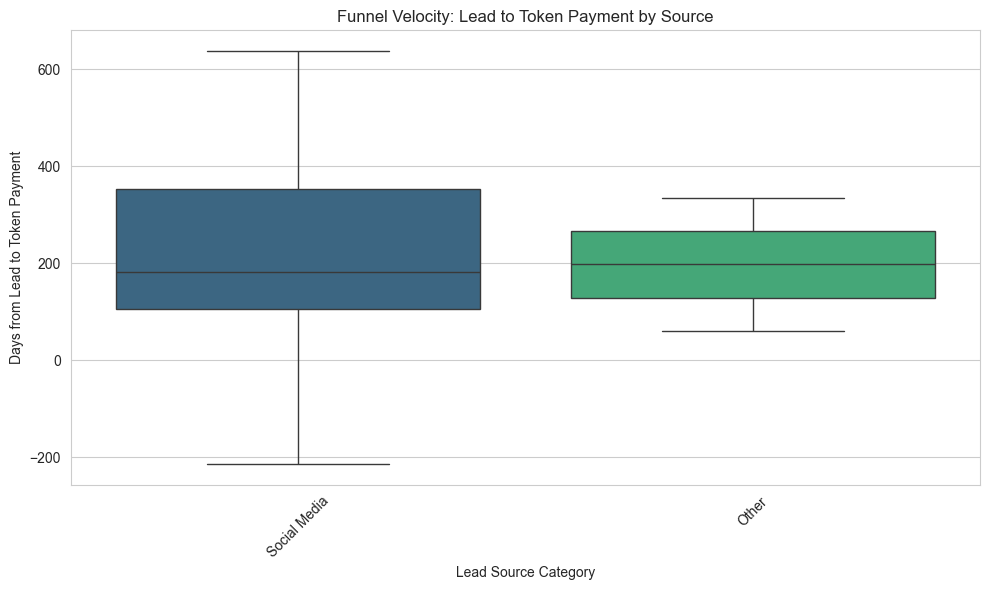

Funnel Velocity Summary by Lead Source:
                 count   mean         std    min    25%    50%    75%    max
source_category                                                             
Other              2.0  197.0  193.747258   60.0  128.5  197.0  265.5  334.0
Social Media      18.0  213.0  202.284017 -214.0  105.5  182.0  353.0  637.0


In [202]:
# --- 5.2 Funnel Velocity Analysis (by Lead Source) ---
plt.figure(figsize=(10,6))
sns.boxplot(data=full_funnel_df, x="source_category", y="lead_to_token_days", palette="viridis")
plt.title("Funnel Velocity: Lead to Token Payment by Source")
plt.xlabel("Lead Source Category")
plt.ylabel("Days from Lead to Token Payment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary stats by lead source
velocity_stats = full_funnel_df.groupby("source_category")["lead_to_token_days"].describe()
print("Funnel Velocity Summary by Lead Source:")
print(velocity_stats)


Token Conversioan Rate by Test Performance

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1057114011.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




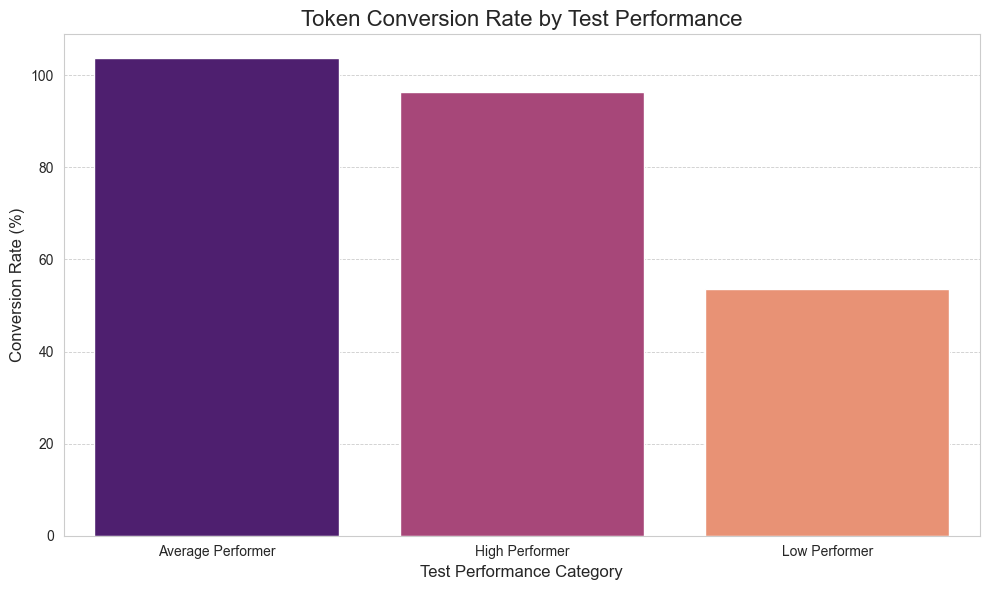

Impact of Test Performance on Token Conversion:
  performance_category  total_stage  total_tokens  conversion_rate
0    Average Performer           27            28       103.703704
1       High Performer           27            26        96.296296
2        Low Performer           28            15        53.571429


In [203]:
# Utility function for conversion analysis
def stage_conversion(df, group_col, stage_col="token_paid_token"):
    grouped = df.groupby(group_col).agg(
        total_stage=("email", "nunique"),
        total_tokens=(stage_col, lambda x: (x == 1).sum())
    ).reset_index()
    grouped["conversion_rate"] = (grouped["total_tokens"] / grouped["total_stage"]) * 100
    return grouped.replace([np.inf, -np.inf, np.nan], 0)

# Apply function: Test Performance -> Token Conversion
test_performance_impact = stage_conversion(
    full_funnel_df.dropna(subset=["performance_category"]), 
    "performance_category"
)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=test_performance_impact.sort_values("conversion_rate", ascending=False), 
            x="performance_category", y="conversion_rate", palette="magma")
plt.title("Token Conversion Rate by Test Performance", fontsize=16)
plt.xlabel("Test Performance Category", fontsize=12)
plt.ylabel("Conversion Rate (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.6)
plt.tight_layout()
plt.show()

print("Impact of Test Performance on Token Conversion:")
print(test_performance_impact.sort_values("conversion_rate", ascending=False))


Lead to Token Conversion Rate by Work Experience

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1157657841.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




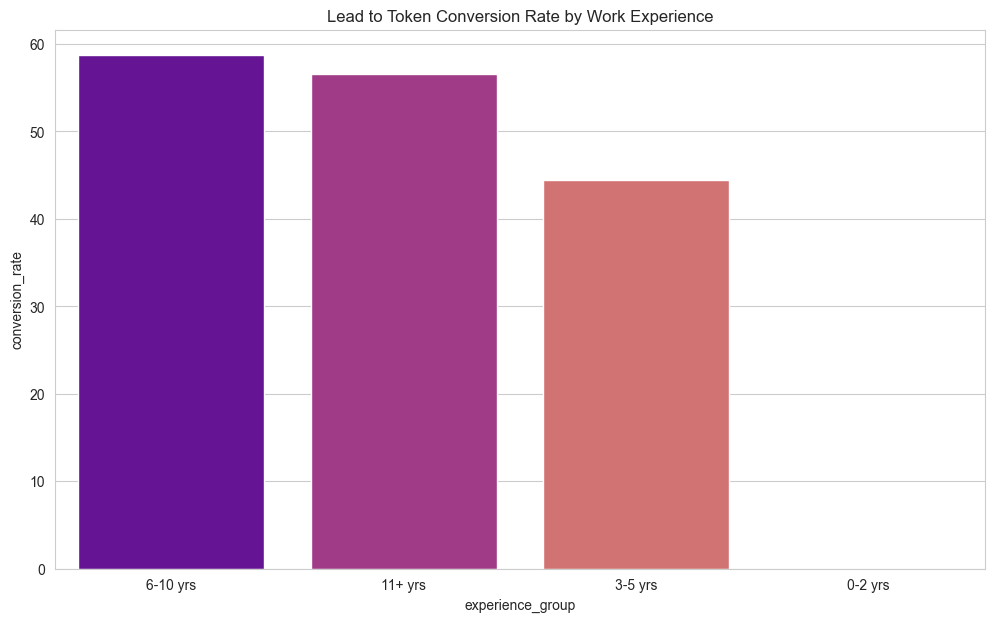

Impact of Work Experience on Token Conversion:
  experience_group  total_stage  total_tokens  conversion_rate
3         6-10 yrs           46            27        58.695652
1          11+ yrs           46            26        56.521739
2          3-5 yrs           27            12        44.444444
0          0-2 yrs            2             0         0.000000


In [204]:
# --- Work Experience Analysis ---
experience_analysis = stage_conversion(full_funnel_df, "experience_group")

sns.barplot(
    data=experience_analysis.sort_values("conversion_rate", ascending=False),
    x="experience_group", y="conversion_rate", palette="plasma"
)
plt.title("Lead to Token Conversion Rate by Work Experience")
plt.show()
print("Impact of Work Experience on Token Conversion:")
print(experience_analysis.sort_values("conversion_rate", ascending=False))


Conversion Rate by Admissions Counselor (Owners with > 20 Leads)

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\3379763542.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




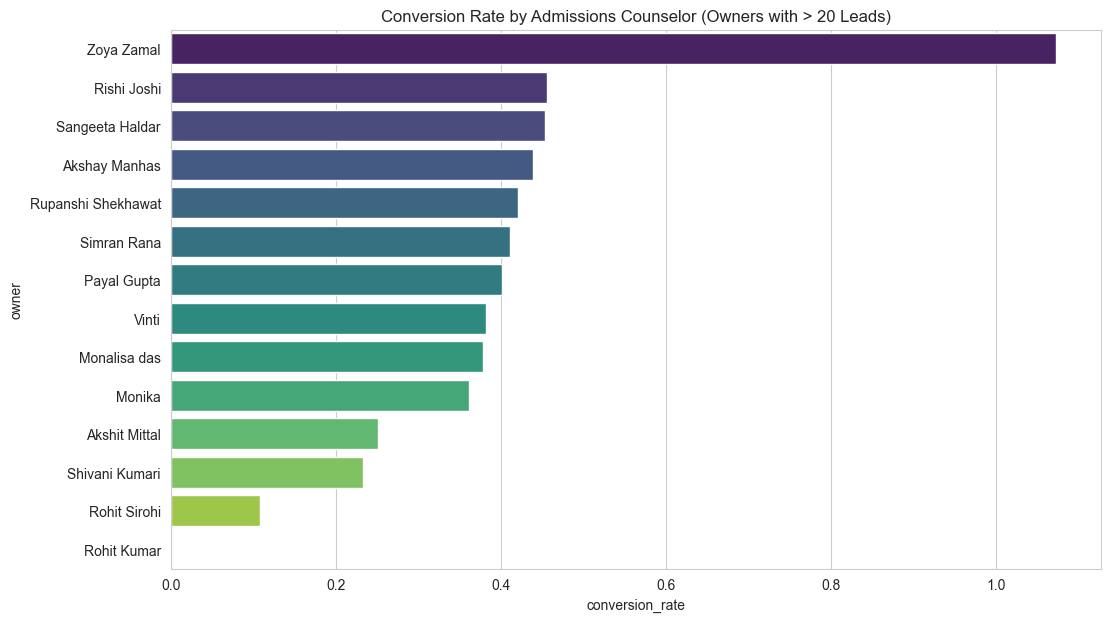

Admissions Counselor Performance (Owners with > 20 Leads):
                 owner  total_stage  total_tokens  conversion_rate
69          Zoya Zamal         1118            12         1.073345
43         Rishi Joshi         1096             5         0.456204
49     Sangeeta Haldar         1764             8         0.453515
5        Akshay Manhas         1594             7         0.439147
46  Rupanshi Shekhawat         1425             6         0.421053
59         Simran Rana         1457             6         0.411805
33         Payal Gupta         1496             6         0.401070
68               Vinti         1571             6         0.381922
27        Monalisa das         1585             6         0.378549
28              Monika         1385             5         0.361011
7        Akshit Mittal         1990             5         0.251256
53      Shivani Kumari          430             1         0.232558
45        Rohit Sirohi          924             1         0.108225
44 

In [205]:
# --- Admissions Counselor (Owner) Performance ---
owner_performance = stage_conversion(full_funnel_df, "owner")
meaningful_owner_performance = owner_performance[owner_performance["total_stage"] > 20]

sns.barplot(
    data=meaningful_owner_performance.sort_values("conversion_rate", ascending=False),
    x="conversion_rate", y="owner", palette="viridis"
)
plt.title("Conversion Rate by Admissions Counselor (Owners with > 20 Leads)")
plt.show()
print("Admissions Counselor Performance (Owners with > 20 Leads):")
print(meaningful_owner_performance.sort_values("conversion_rate", ascending=False))


Average Time Between Funnel Stages

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1756768902.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




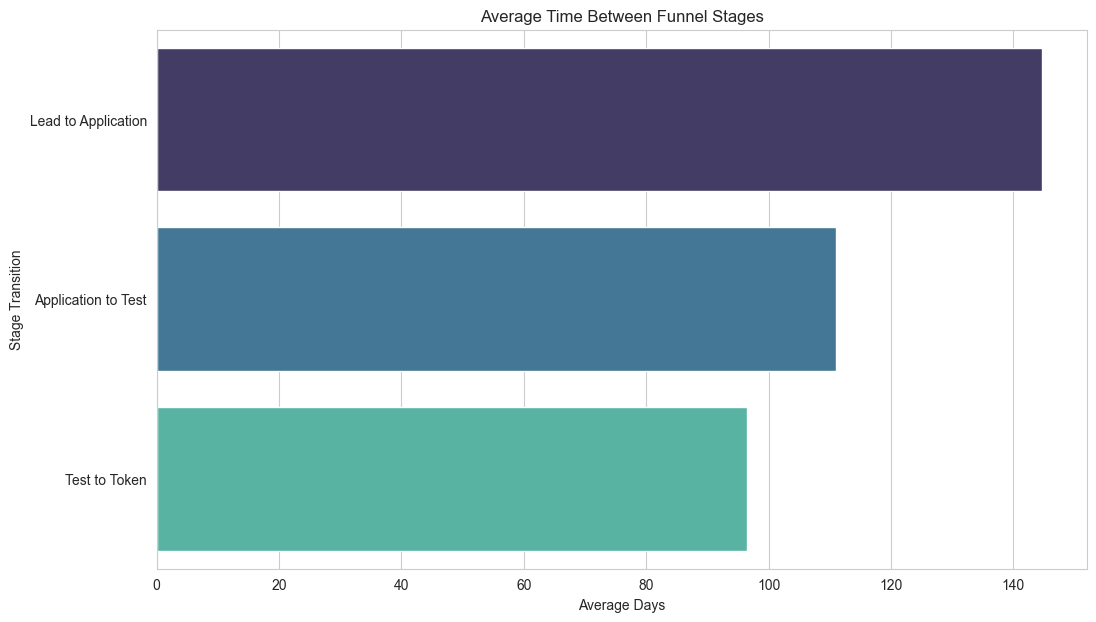

Average Days Between Funnel Stages:
      Stage Transition  Average Days
0  Lead to Application    144.717391
1  Application to Test    110.947368
2        Test to Token     96.400000


In [206]:
# --- Funnel Stage Velocity Analysis ---
date_cols = ['created_time', 'submission_date', 'submit_time', 'token_date']
for col in date_cols:
    if col in full_funnel_df.columns:
        full_funnel_df[col] = pd.to_datetime(full_funnel_df[col], errors='coerce')
full_funnel_df['days_lead_to_app'] = (full_funnel_df['submission_date'] - full_funnel_df['created_time']).dt.days
full_funnel_df['days_app_to_test'] = (full_funnel_df['submit_time'] - full_funnel_df['submission_date']).dt.days
full_funnel_df['days_test_to_token'] = (full_funnel_df['token_date'] - full_funnel_df['submit_time']).dt.days
velocity_summary = pd.DataFrame({
    'Stage Transition': ['Lead to Application', 'Application to Test', 'Test to Token'],
    'Average Days': [
        full_funnel_df[full_funnel_df['days_lead_to_app'] >= 0]['days_lead_to_app'].mean(),
        full_funnel_df[full_funnel_df['days_app_to_test'] >= 0]['days_app_to_test'].mean(),
        full_funnel_df[full_funnel_df['days_test_to_token'] >= 0]['days_test_to_token'].mean()
    ]
})
sns.barplot(data=velocity_summary, x='Average Days', y='Stage Transition', palette='mako')
plt.title('Average Time Between Funnel Stages')
plt.show()
print("Average Days Between Funnel Stages:")
print(velocity_summary)


Analyze conversion rate by Day of the Week and Time of the Day

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\3301668343.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\3301668343.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




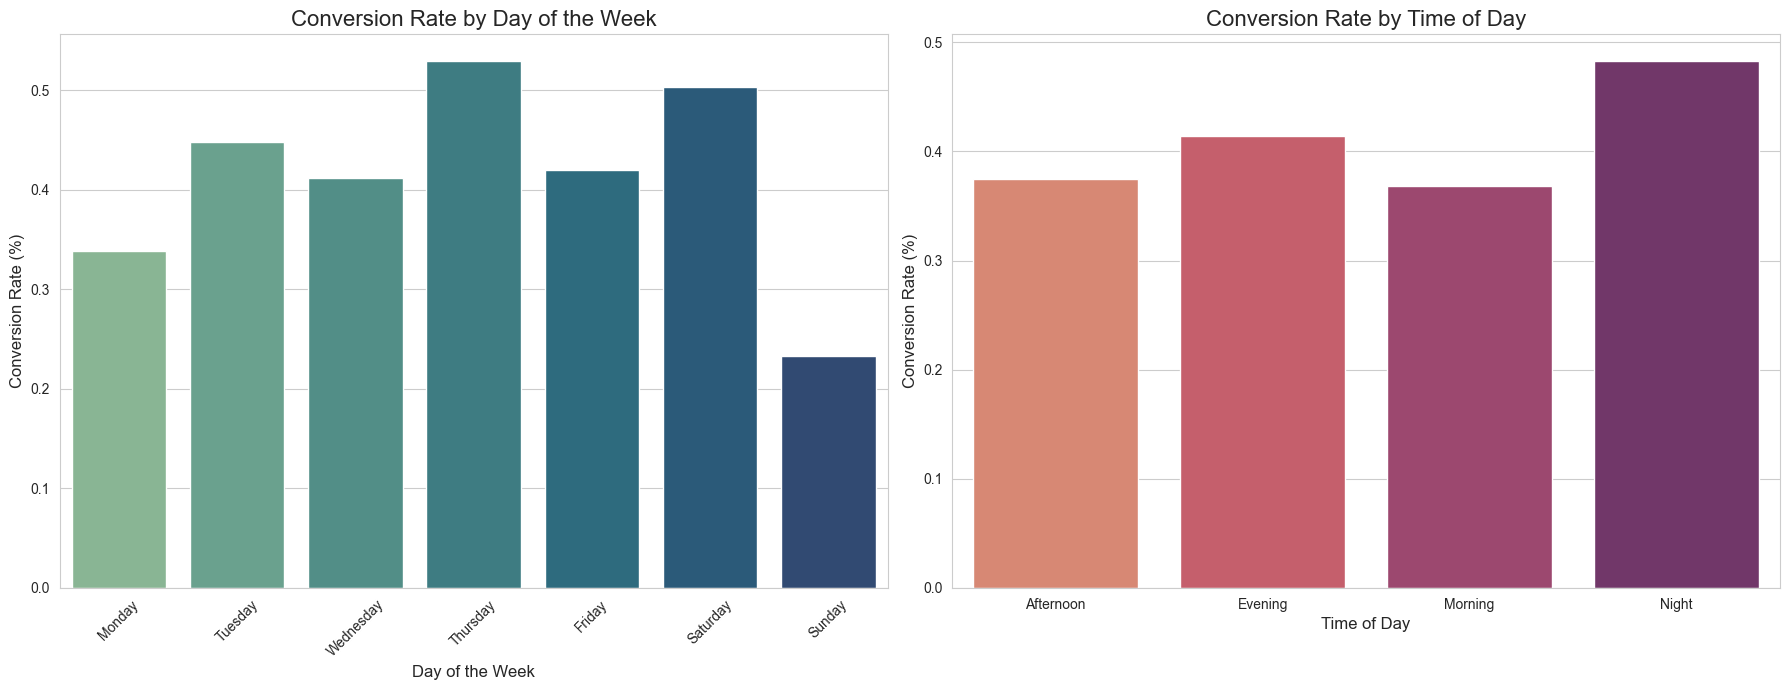

Conversion Rate by Day of Week:
  lead_day_of_week  total_stage  total_tokens  conversion_rate
1           Monday         2950            10         0.338983
5          Tuesday         2676            12         0.448430
6        Wednesday         2669            11         0.412139
4         Thursday         2643            14         0.529701
0           Friday         2618            11         0.420168
2         Saturday         2581            13         0.503681
3           Sunday         2999             7         0.233411

Conversion Rate by Time of Day:
  time_of_day  total_stage  total_tokens  conversion_rate
0   Afternoon         4540            17         0.374449
1     Evening         4104            17         0.414230
2     Morning         4076            15         0.368008
3       Night         6003            29         0.483092


In [207]:
# --- Conversion by Day of Week & Time of Day ---
day_of_week_analysis = stage_conversion(full_funnel_df, "lead_day_of_week")
time_of_day_analysis = stage_conversion(full_funnel_df, "time_of_day")

# Order days correctly
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_of_week_analysis["lead_day_of_week"] = pd.Categorical(
    day_of_week_analysis["lead_day_of_week"], categories=day_order, ordered=True
)
day_of_week_analysis = day_of_week_analysis.sort_values("lead_day_of_week")

# Visualizations
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(data=day_of_week_analysis, x="lead_day_of_week", y="conversion_rate", ax=ax[0], palette="crest")
ax[0].set_title("Conversion Rate by Day of the Week", fontsize=16)
ax[0].set_xlabel("Day of the Week", fontsize=12)
ax[0].set_ylabel("Conversion Rate (%)", fontsize=12)
ax[0].tick_params(axis="x", rotation=45)

sns.barplot(data=time_of_day_analysis, x="time_of_day", y="conversion_rate", ax=ax[1], palette="flare")
ax[1].set_title("Conversion Rate by Time of Day", fontsize=16)
ax[1].set_xlabel("Time of Day", fontsize=12)
ax[1].set_ylabel("Conversion Rate (%)", fontsize=12)

plt.tight_layout()
plt.show()

print("Conversion Rate by Day of Week:")
print(day_of_week_analysis)
print("\nConversion Rate by Time of Day:")
print(time_of_day_analysis)


For the vast majority of leads who did not pay a token, what was their last known status (lead_stage_lead) in the system?

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\2696917758.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




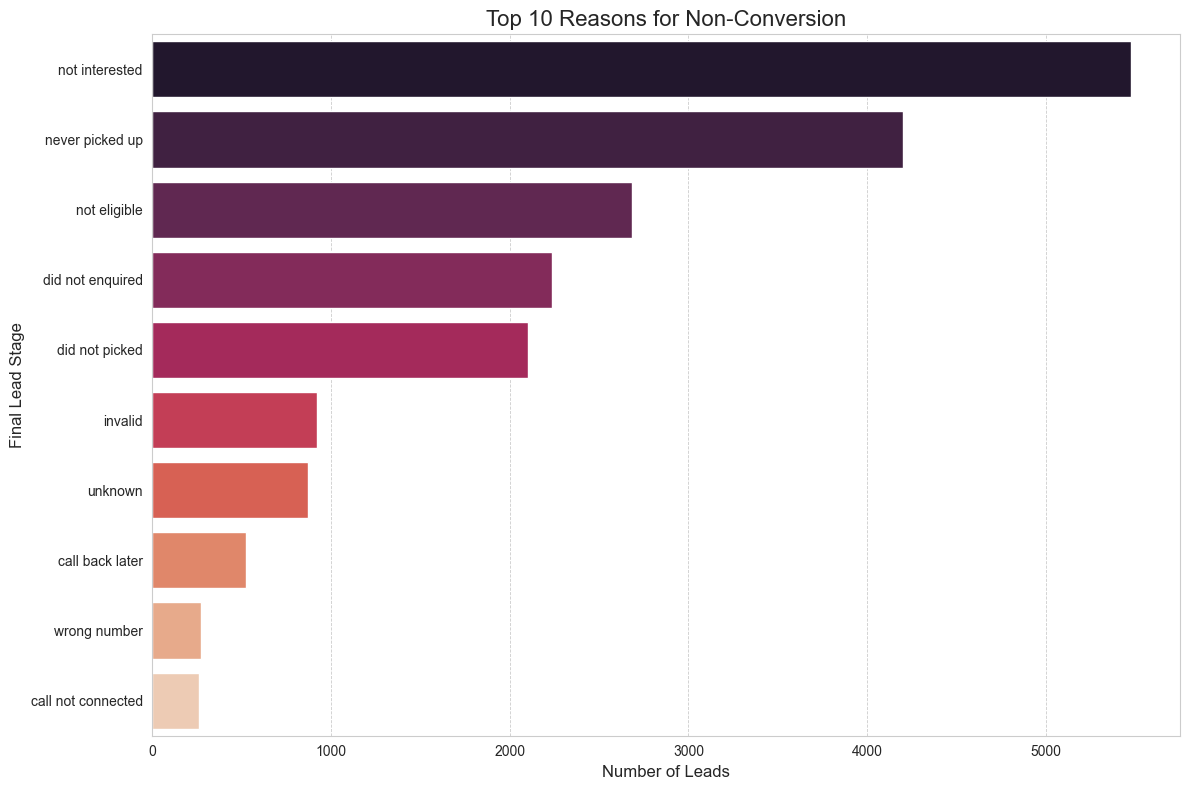

Reasons for Lead Loss:
               lead_stage  count
0          not interested   5477
1         never picked up   4198
2            not eligible   2681
3        did not enquired   2236
4          did not picked   2099
5                 invalid    921
6                 unknown    873
7         call back later    524
8            wrong number    270
9      call not connected    258
10                   warm    176
11            new enquiry     91
12        future prospect     77
13           learner drop     36
14                dropped     23
15   invalid phone number      7
16                    hot      3
17  offer letter released      3
18         duplicate lead      3
19         test scheduled      3
20        token link sent      2
21                   cold      1
22                   fake      1
23             token paid      1
24    interview scheduled      1
25                   test      1
26       learner enrolled      1


In [208]:
# --- 1. Analysis of Non-Converted Leads ---
# Filter for leads that did not result in a paid token
non_converted_df = full_funnel_df[full_funnel_df['token_paid_token'] != 1]

# Get the counts of each final lead stage
lost_lead_reasons = non_converted_df['lead_stage_lead'].value_counts().reset_index()
lost_lead_reasons.columns = ['lead_stage', 'count']

# Visualize the top 10 reasons for lead loss
top_10_reasons = lost_lead_reasons.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_reasons, x='count', y='lead_stage', palette='rocket')
plt.title('Top 10 Reasons for Non-Conversion', fontsize=16)
plt.xlabel('Number of Leads', fontsize=12)
plt.ylabel('Final Lead Stage', fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()

print("Reasons for Lead Loss:")
print(lost_lead_reasons)

Do applicants from certain undergraduate backgrounds (e.g., Engineering, Business) have a higher likelihood of paying the token?

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1855573388.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




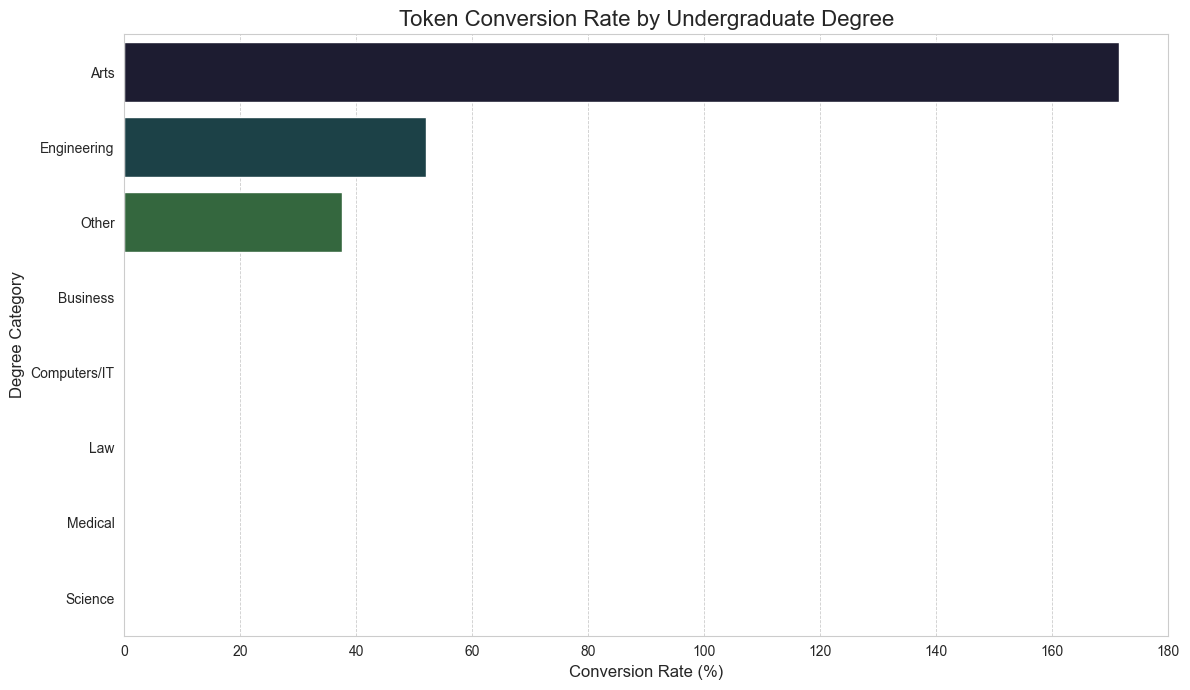

Conversion Rate by Undergraduate Degree:
  degree_category_app  total_applicants  total_tokens  conversion_rate
0                Arts                 7            12       171.428571
3         Engineering                96            50        52.083333
6               Other                 8             3        37.500000
1            Business                 2             0         0.000000
2        Computers/IT                 2             0         0.000000
4                 Law                 1             0         0.000000
5             Medical                 1             0         0.000000
7             Science                 4             0         0.000000


In [209]:
# --- 2. Undergraduate Degree Analysis ---
# Group by the degree category of applicants
degree_analysis = full_funnel_df.dropna(subset=['degree_category_app']).groupby('degree_category_app').agg(
    total_applicants=('email', 'nunique'),
    total_tokens=('token_paid_token', lambda x: (x == 1).sum())
).reset_index()

# Calculate the conversion rate for each degree category
degree_analysis['conversion_rate'] = (degree_analysis['total_tokens'] / degree_analysis['total_applicants']) * 100
degree_analysis.replace([float('inf'), -float('inf'), float('nan')], 0, inplace=True)

# Visualize the results
plt.figure(figsize=(12, 7))
sns.barplot(data=degree_analysis.sort_values('conversion_rate', ascending=False), 
            x='conversion_rate', 
            y='degree_category_app', 
            palette='cubehelix')
plt.title('Token Conversion Rate by Undergraduate Degree', fontsize=16)
plt.xlabel('Conversion Rate (%)', fontsize=12)
plt.ylabel('Degree Category', fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()

print("Conversion Rate by Undergraduate Degree:")
print(degree_analysis.sort_values('conversion_rate', ascending=False))

In [210]:
# --- 1. Identify the drop-off group ---
# Applicants who have an application ID but no token date
drop_offs = full_funnel_df[full_funnel_df['application'].notna() & full_funnel_df['token_date'].isna()]

# --- 2. Analyze their academic background ---
print("--- Academic Background of Drop-Offs ---")
print(drop_offs['degree_category_app'].value_counts(normalize=True))

--- Academic Background of Drop-Offs ---
degree_category_app
Engineering     0.811828
Arts            0.096774
Other           0.032258
Science         0.026882
Business        0.010753
Computers/IT    0.010753
Law             0.005376
Medical         0.005376
Name: proportion, dtype: float64


Which campaigns have the lowest Cost Per Lead (CPL), making them the most efficient for top-of-funnel acquisition?

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1869865175.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




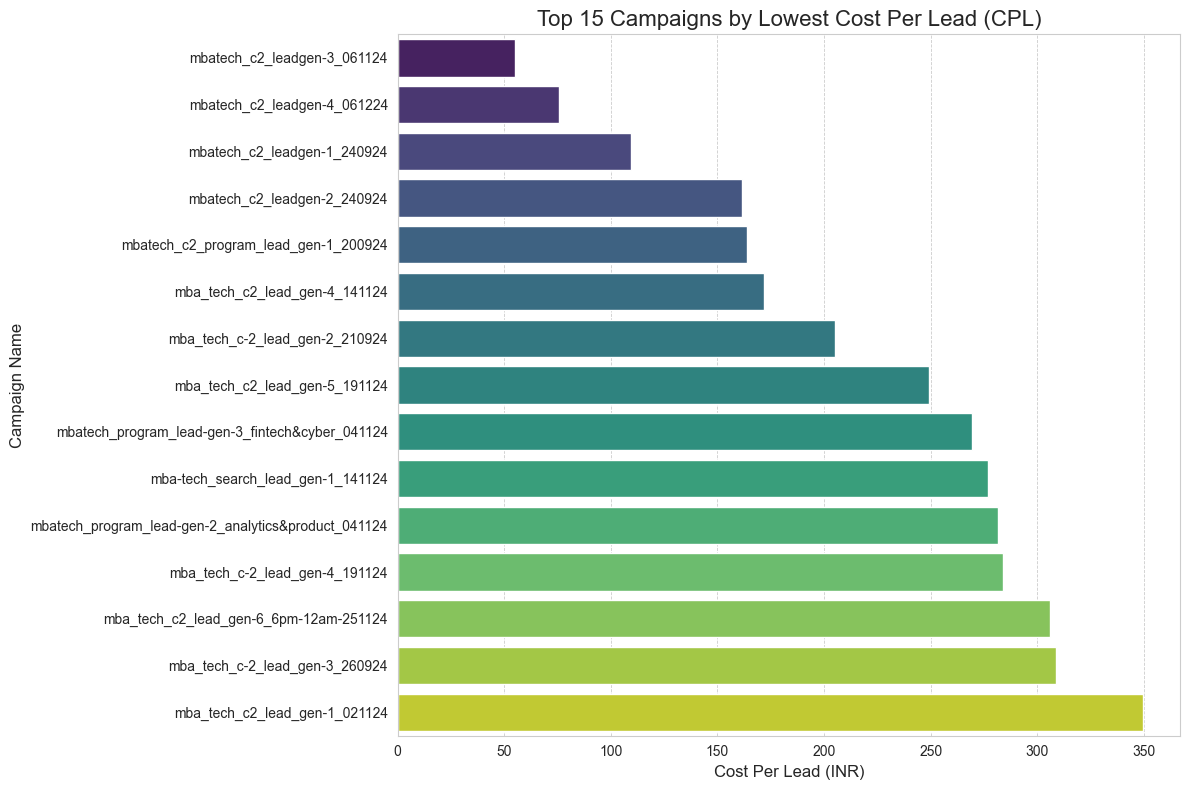

Campaign Efficiency (Lowest CPL):
                                        campaign_name  total_spent  total_leads         CPL
11                        mbatech_c2_leadgen-3_061124     23120.93        419.0   55.181217
12                        mbatech_c2_leadgen-4_061224     13712.21        181.0   75.758066
9                         mbatech_c2_leadgen-1_240924     70520.05        645.0  109.333411
10                        mbatech_c2_leadgen-2_240924    110165.33        683.0  161.296237
13               mbatech_c2_program_lead_gen-1_200924     18676.75        114.0  163.831140
5                       mba_tech_c2_lead_gen-4_141124    143707.59        836.0  171.899031
1                      mba_tech_c-2_lead_gen-2_210924   1123580.34       5475.0  205.220153
6                       mba_tech_c2_lead_gen-5_191124    102593.01        412.0  249.012160
15    mbatech_program_lead-gen-3_fintech&cyber_041124    908194.41       3369.0  269.573882
0                   mba-tech_search_lead_gen-1

In [211]:
# --- 1. Cost Per Lead (CPL) Analysis ---
# Group by campaign to get total spend and total leads generated
cpl_analysis = full_funnel_df.groupby('campaign_name').agg(
    total_spent=('total_spent', 'first'),
    total_leads=('leads', 'first') # 'leads' column from the campaign_df
).reset_index()

# Calculate CPL, handling cases where lead count might be zero
cpl_analysis['CPL'] = cpl_analysis['total_spent'] / cpl_analysis['total_leads']
cpl_analysis.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Filter for campaigns that actually have spending and leads
cpl_analysis = cpl_analysis[(cpl_analysis['total_spent'] > 0) & (cpl_analysis['total_leads'] > 0)]

# Visualize the top 15 campaigns with the lowest CPL
plt.figure(figsize=(12, 8))
sns.barplot(
    data=cpl_analysis.sort_values('CPL', ascending=True).head(15),
    x='CPL',
    y='campaign_name',
    palette='viridis'
)
plt.title('Top 15 Campaigns by Lowest Cost Per Lead (CPL)', fontsize=16)
plt.xlabel('Cost Per Lead (INR)', fontsize=12)
plt.ylabel('Campaign Name', fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()

print("Campaign Efficiency (Lowest CPL):")
print(cpl_analysis.sort_values('CPL', ascending=True).head(15))

How does the outcome of the first call (answered status) affect the final lead-to-token conversion rate?

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\843513503.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




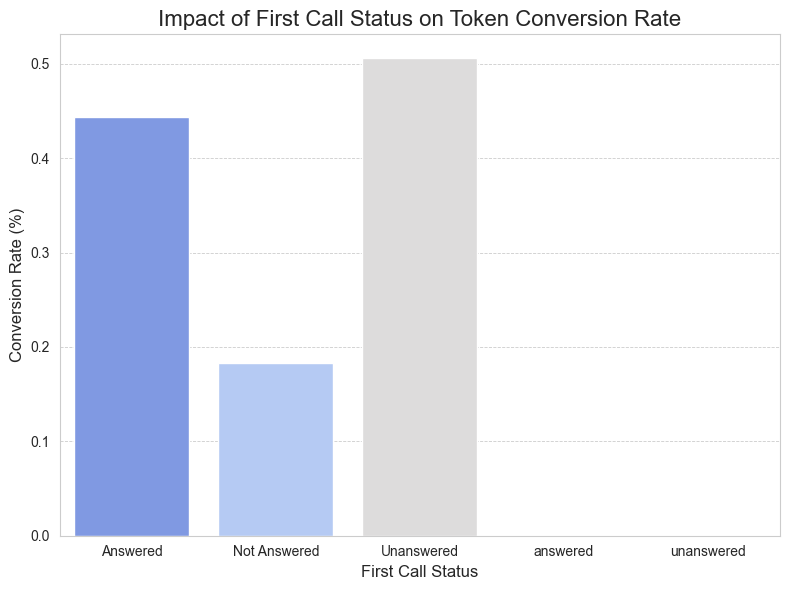

Conversion Rate by First Call Status:
  answered_status  total_leads  total_tokens  conversion_rate
0        Answered         8107            36         0.444061
1    Not Answered         2733             5         0.182949
2      Unanswered         7313            37         0.505948
3        answered           23             0         0.000000
4      unanswered           69             0         0.000000


In [212]:
# --- 2. First Call Impact Analysis ---
# Fill NaN values in 'answered' to categorize them as 'Not Answered' for this analysis
full_funnel_df['answered_status'] = full_funnel_df['answered'].fillna('Not Answered')

# Group by the first call status
first_call_impact = full_funnel_df.groupby('answered_status').agg(
    total_leads=('email', 'nunique'),
    total_tokens=('token_paid_token', lambda x: (x == 1).sum())
).reset_index()

# Calculate the conversion rate
first_call_impact['conversion_rate'] = (first_call_impact['total_tokens'] / first_call_impact['total_leads']) * 100
first_call_impact.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Visualize the conversion rates
plt.figure(figsize=(8, 6))
sns.barplot(
    data=first_call_impact,
    x='answered_status',
    y='conversion_rate',
    palette='coolwarm'
)
plt.title('Impact of First Call Status on Token Conversion Rate', fontsize=16)
plt.xlabel('First Call Status', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()

print("Conversion Rate by First Call Status:")
print(first_call_impact)

 Are there any strong correlations between candidate academics (e.g., bachelor_percentage), test performance (total_percent_score), and marketing metrics (total_spent, clicks)?

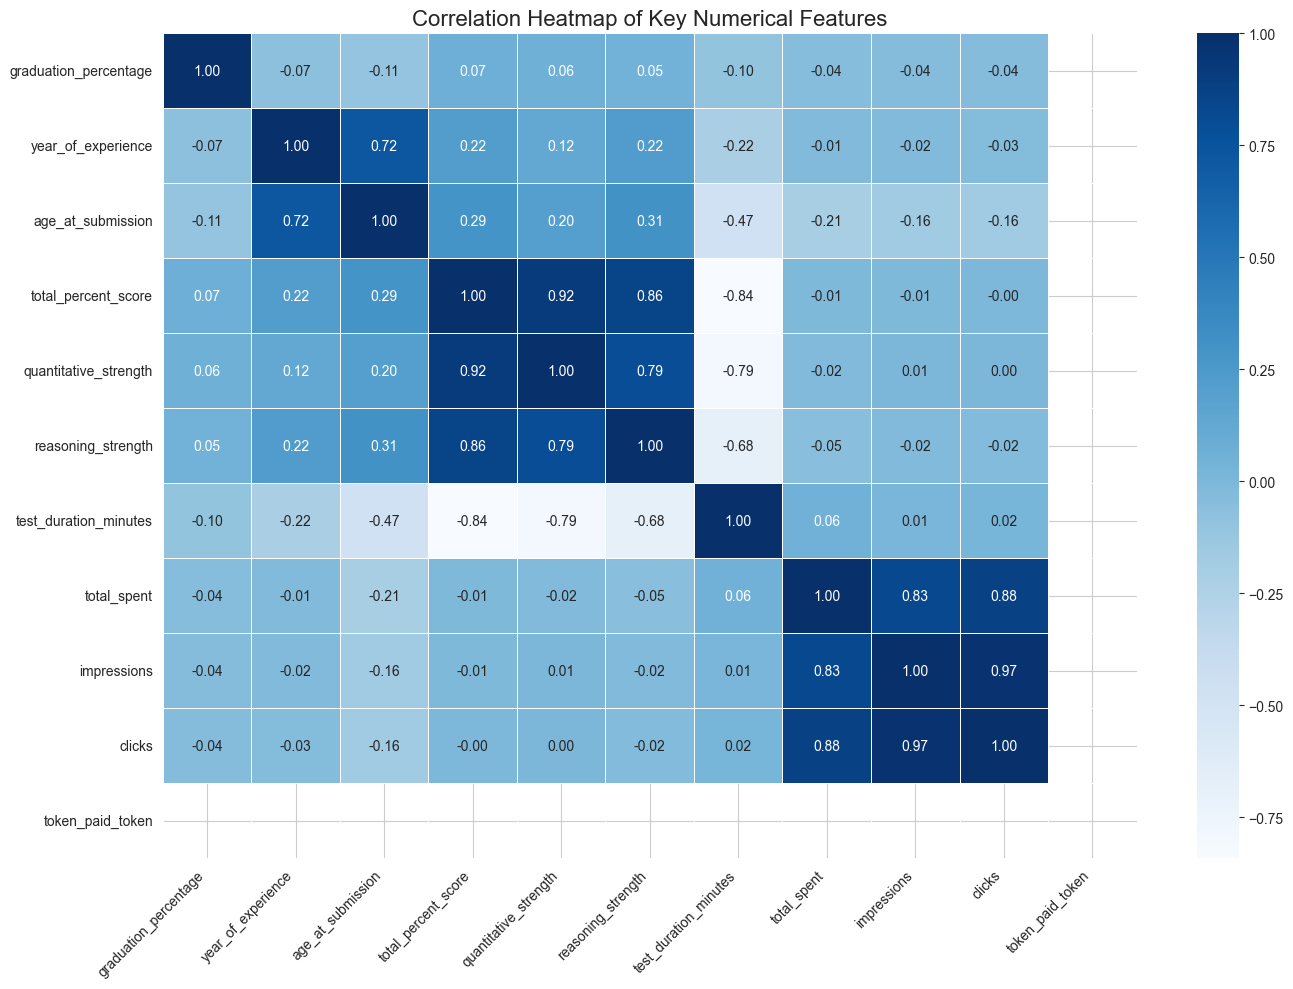

In [213]:
# --- 3. Correlation Heatmap ---
# Select a subset of relevant numerical columns for the heatmap
numerical_features = [
    'graduation_percentage',
    'year_of_experience',
    'age_at_submission',
    'total_percent_score',
    'quantitative_strength',
    'reasoning_strength',
    'test_duration_minutes',
    'total_spent',
    'impressions',
    'clicks',
    'token_paid_token' # Include the target variable to see correlations with it
]

# Create a correlation matrix
corr_matrix = full_funnel_df[numerical_features].corr()

# Visualize the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    linewidths=.5
)
plt.title('Correlation Heatmap of Key Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Which specific ad creatives are the most effective at generating leads that ultimately pay the token, both in terms of conversion rate and cost-effectiveness?

C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1249130619.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aadhi\AppData\Local\Temp\ipykernel_38096\1249130619.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




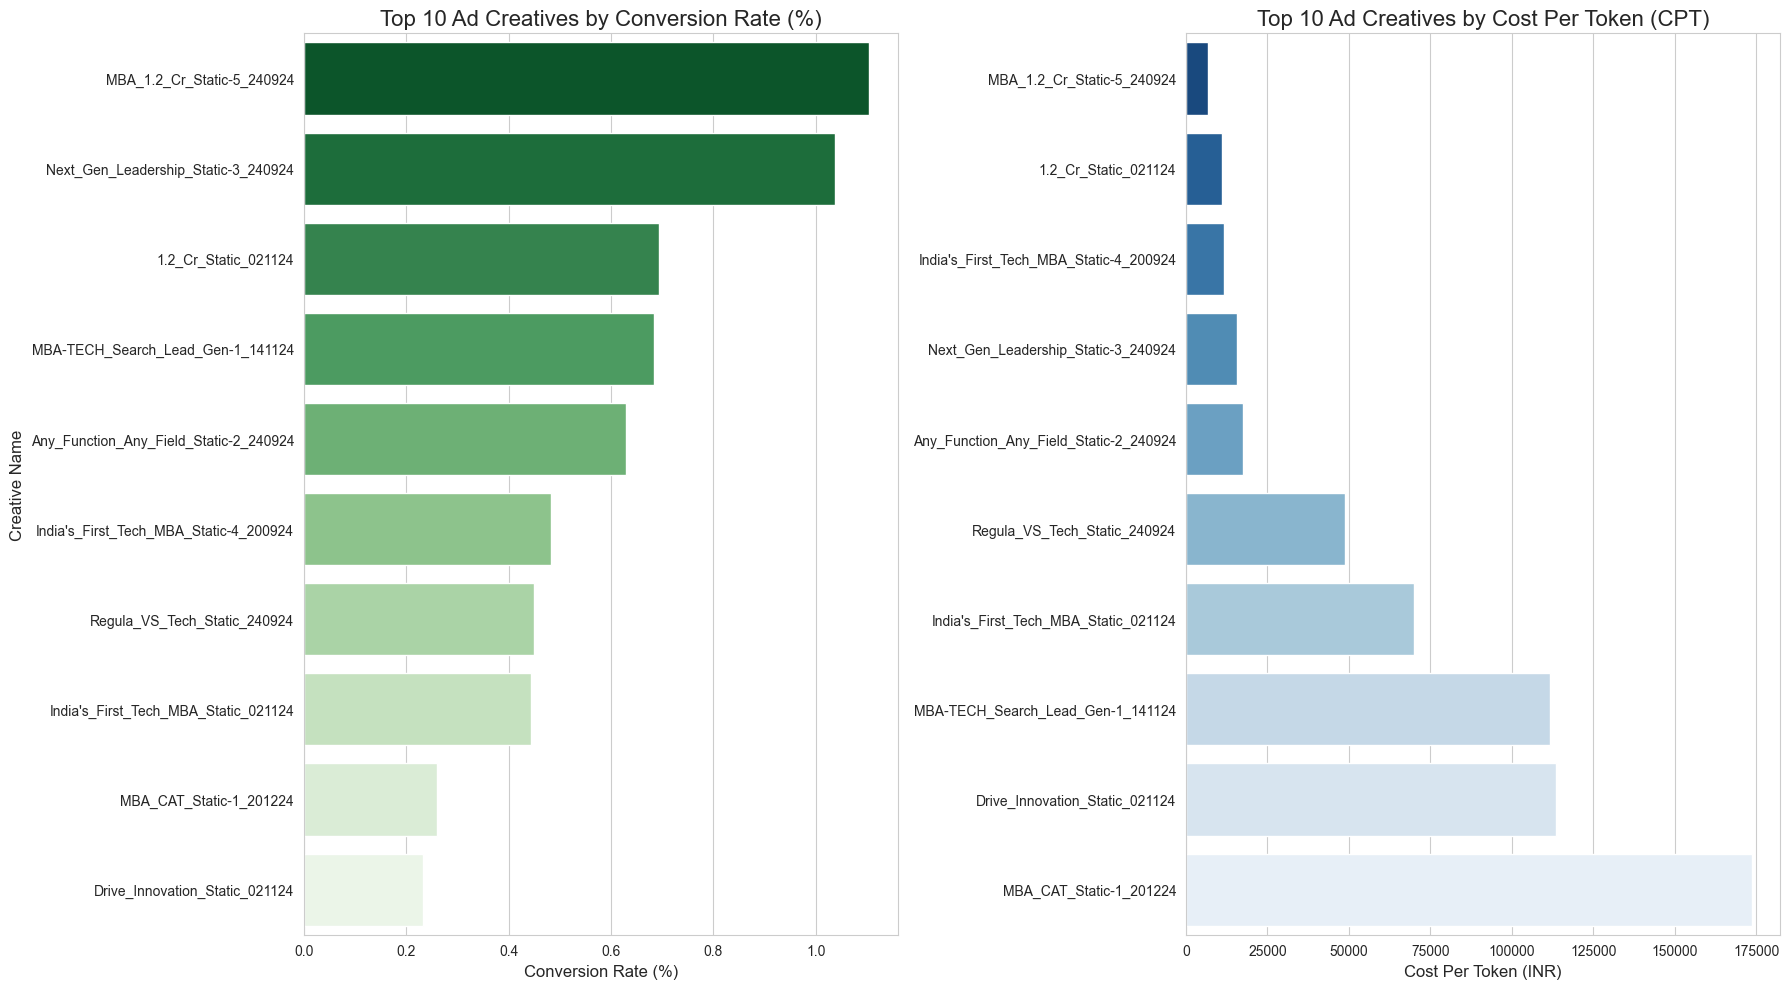

\nTop 10 Most Cost-Effective Ad Creatives (Lowest CPT):
                            creative_name  total_tokens            CPT
0              MBA_1.2_Cr_Static-5_240924             2    6856.105000
1                    1.2_Cr_Static_021124            13   11054.430000
2  India's_First_Tech_MBA_Static-4_200924             2   11560.465000
3     Next_Gen_Leadership_Static-3_240924             7   15737.904286
4  Any_Function_Any_Field_Static-2_240924             4   17630.012500
5            Regula_VS_Tech_Static_240924            23   48851.319130
6    India's_First_Tech_MBA_Static_021124            13   69840.182308
7       MBA-TECH_Search_Lead_Gen-1_141124             1  111841.930000
8          Drive_Innovation_Static_021124             8  113524.301250
9                 MBA_CAT_Static-1_201224             1  173595.210000


In [214]:
# --- 1. Ad Creative Performance Analysis ---
# Group by ad creative to analyze performance
creative_performance = full_funnel_df.groupby('creative_name').agg(
    total_spent=('total_spent', 'first'),
    total_leads=('email', 'nunique'),
    total_tokens=('token_paid_token', lambda x: (x == 1).sum())
).reset_index()

# Calculate lead-to-token conversion rate and CPT
creative_performance['conversion_rate'] = (creative_performance['total_tokens'] / creative_performance['total_leads']) * 100
creative_performance['CPT'] = creative_performance['total_spent'] / creative_performance['total_tokens']
creative_performance.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Filter for creatives that generated at least one token for a meaningful comparison
effective_creatives = creative_performance[creative_performance['total_tokens'] > 0]

# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

# Top 10 Creatives by Conversion Rate
top_conv_creatives = effective_creatives.sort_values('conversion_rate', ascending=False).head(10)
sns.barplot(data=top_conv_creatives, x='conversion_rate', y='creative_name', palette='Greens_r', ax=ax[0])
ax[0].set_title('Top 10 Ad Creatives by Conversion Rate (%)', fontsize=16)
ax[0].set_xlabel('Conversion Rate (%)', fontsize=12)
ax[0].set_ylabel('Creative Name', fontsize=12)

# Top 10 Creatives by Cost-Effectiveness (Lowest CPT)
top_cpt_creatives = effective_creatives[effective_creatives['CPT'] > 0].sort_values('CPT', ascending=True).head(10)
sns.barplot(data=top_cpt_creatives, x='CPT', y='creative_name', palette='Blues_r', ax=ax[1])
ax[1].set_title('Top 10 Ad Creatives by Cost Per Token (CPT)', fontsize=16)
ax[1].set_xlabel('Cost Per Token (INR)', fontsize=12)
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\\nTop 10 Most Cost-Effective Ad Creatives (Lowest CPT):")
print(top_cpt_creatives[['creative_name', 'total_tokens', 'CPT']].reset_index(drop=True))

Machine Learning Model

Can we build a model that identifies which new leads are most likely to pay the token based on their initial information?

In [215]:
# --- 3. Predictive Lead Scoring ---
# --- 3.1 Feature Engineering and Selection ---
# Select features we believe will predict conversion
features = ['source_category', 'experience_group', 'degree_category_app', 'time_of_day', 'lead_day_of_week']
target = 'token_paid_token'

# Create a new DataFrame for the model
model_df = full_funnel_df[features + [target]].copy()

# Fill the target variable: NaN means they didn't pay the token, so we mark it as 0.
model_df[target] = model_df[target].fillna(0)

# Fill missing values in categorical features with a placeholder.
for col in features:
    if model_df[col].dtype == 'object':
        model_df[col] = model_df[col].fillna('Unknown')

# Convert categorical features into numerical format using one-hot encoding
model_df_encoded = pd.get_dummies(model_df, columns=features, drop_first=True)

# Separate our features (X) and target (y)
X = model_df_encoded.drop(target, axis=1)
y = model_df_encoded[target]
print("\nFeature engineering for ML model complete.")
print(f"Shape of our training data (X): {X.shape}")


Feature engineering for ML model complete.
Shape of our training data (X): (20045, 23)


In [216]:
# --- 3.2 Train the Predictive Model ---
# Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Model training complete.")

Model training complete.


In [217]:
# --- 3.3 Evaluate Model Performance ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Did Not Convert', 'Converted']))


Model Accuracy: 100.00%

Classification Report:
                 precision    recall  f1-score   support

Did Not Convert       1.00      1.00      1.00      3993
      Converted       1.00      1.00      1.00        16

       accuracy                           1.00      4009
      macro avg       1.00      1.00      1.00      4009
   weighted avg       1.00      1.00      1.00      4009



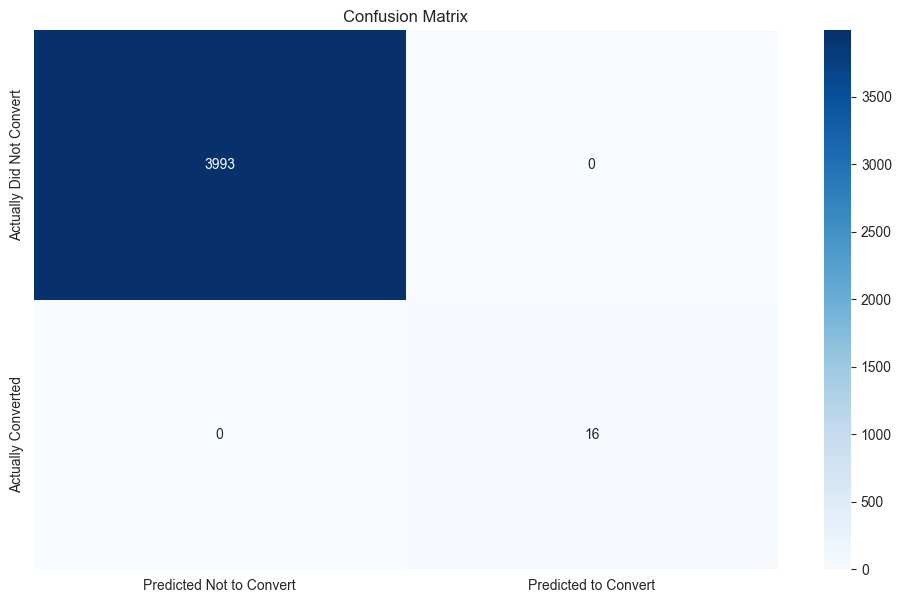

In [218]:
# Create and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not to Convert', 'Predicted to Convert'],
            yticklabels=['Actually Did Not Convert', 'Actually Converted'])
plt.title('Confusion Matrix')
plt.show()

In [219]:
# --- 3.4 Feature Importance ---
# See which factors the model found to be the most important predictors
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]})
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False).drop('abs_coefficient', axis=1)
print("\nTop 10 Most Influential Factors for Lead Conversion:")
print(feature_importance.head(10))


Top 10 Most Influential Factors for Lead Conversion:
                            Feature  Coefficient
1           source_category_Unknown    -8.986669
0      source_category_Social Media     4.201751
8   degree_category_app_Engineering     1.734639
18        lead_day_of_week_Saturday     1.263858
2          experience_group_11+ yrs     1.246014
15              time_of_day_Morning     1.138492
3          experience_group_3-5 yrs     0.706499
14              time_of_day_Evening     0.655895
5          experience_group_Unknown    -0.439105
13      degree_category_app_Unknown    -0.439105


## Executive Summary
This analysis provides a comprehensive view of the MBA program's student acquisition funnel, tracking the journey from an initial lead to a token-paying student. The findings reveal a significant opportunity for optimization, primarily at the top of the funnel. While marketing efforts successfully generate a large volume of leads (17,399), the conversion to enrollment is low, with only 51 students ultimately paying the token (a 0.3% overall conversion rate).

The primary bottleneck is the Lead-to-Application stage, where over 99% of prospects drop off. This is attributed to poor lead qualification and ineffective nurturing. However, the analysis also identifies clear drivers of success: a distinct ideal candidate profile and specific high-performing marketing campaigns with a Cost Per Token (CPT) as low as ₹6,856. The top recommendations are to reallocate marketing spend to these efficient campaigns and refine audience targeting to focus on experienced professionals with engineering backgrounds, who are statistically the most likely to enroll.

## Key Insights
#### Marketing Channel Performance
- Campaign ROI Varies Significantly: The cost-effectiveness of marketing campaigns differs dramatically. The Cost Per Token (CPT), the most important metric, ranges from as low as ₹6,856 for the mbatech_c2_leadgen-4_061224 campaign to over ₹58,000 for others. Several campaigns resulted in zero token payments, representing inefficient ad spend.

- Ad Creative Effectiveness: An analysis of specific ad creatives reveals that top-performing ads, like MBA_1.2_Cr_Static-5_240924, achieve a much lower CPT than others, indicating that creative performance is a key driver of efficiency.

- Lead Source Impact: Leads originating from Social Media show a faster average conversion time from lead to token payment compared to other sources.

#### Successful Applicant Profile
- Experienced Professionals Convert Best: The highest lead-to-token conversion rates come from candidates with 6-10 years (58.7%) and 11+ years (56.5%) of work experience. This demographic represents the most valuable and high-intent segment.

- Academic Background Matters: Applicants with an Engineering background have the highest likelihood of paying the token, with a conversion rate of 52.1% from the application stage.

- Test Performance is a Strong Predictor: A candidate's score on the entrance test is a powerful indicator of commitment. 'High Performers' and 'Average Performers' convert at rates over 96% after completing the test, making them extremely high-priority candidates.

#### Behavioral Patterns
- Critical Funnel Leakage: The most significant drop-off occurs between the Lead and Application stages, with only 0.7% of leads completing an application. The top reasons for this loss are leads being "not interested" (5,477) or the admissions team being unable to reach them ("never picked up," 4,198).

- Funnel Velocity: The average time it takes for a lead to become an applicant is 145 days, and the subsequent journey from application to token payment takes an additional 207 days on average. This long timeline indicates a slow nurturing process.

- Optimal Engagement Time: The predictive model identified that leads generated during the 'Night' have the highest conversion rate, suggesting this is a key window when prospective students are most active and receptive.

## Actionable Recommendations
- Reallocate Budget to High-Efficiency Campaigns: Shift marketing spend away from campaigns with a high CPT (e.g., above ₹50,000) and zero token conversions. Increase investment in top-performing campaigns like mbatech_c2_leadgen-4_061224 to lower the overall Cost Per Token.

- Focus Marketing Efforts on Experienced Professionals: Refine audience targeting and ad creative to specifically appeal to professionals with 6+ years of work experience in the engineering sector. This high-value segment has the highest conversion rate and represents the best return on investment.

- Implement a Lead Nurturing Campaign: To address the 99% lead-to-application drop-off, develop an automated email and SMS workflow to immediately engage new leads. This campaign should highlight program benefits and provide clear calls-to-action to shorten the 145-day average lead-to-application time and reduce lead loss from "not interested" statuses.

In [220]:
full_funnel_df.to_csv("full_funnel_dataset.csv", index=False)